# <center> Deep Learning Project:

## Members:
> - __Ahmed Abdelazeem__ (m20210433)
> - __Omar Jarir__ (m20201378)  
> - __Chung-Ting Huang__ (m20210437) 
> - __Pedro Moura Gomes__ (m20200322)

***

## Objective
- __The objective of this notebook is to perform hyperparameters tuning:__
- Some references:
   - https://neptune.ai/blog/keras-tuner-tuning-hyperparameters-deep-learning-model/amp
   - https://keras.io/guides/keras_tuner/getting_started/
   - https://keras.io/api/utils/serialization_utils/
   - https://www.tensorflow.org/tutorials/keras/keras_tuner
   - https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

## Install Packages

In [1]:
# !pip install keras-tuner --upgrade
# !pip install -q -U keras-tuner
# !pip install findspark
# !pip install tensorflow-addons

In [2]:
import time
t1 = time.perf_counter()

- __Importing the necessary libraries 📚:__

In [3]:
import numpy as np
import random as python_random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras 
import keras_tuner as kt
import keras.backend as K
import tensorflow_addons as tfa

In [4]:
from operator import add
from keras.models import Model, Sequential
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, History, ReduceLROnPlateau 
from keras import optimizers

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif 
from sklearn.utils import class_weight

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE

import IPython

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
SEED = 2022
MAX_TRIALS = 50

Fixing the random number seed to ensure that the results are reproducible.

In [7]:
session = K.get_session()

np.random.seed(SEED)
tf.random.set_seed(SEED)
python_random.seed(SEED)

- __Helper functions:__

In [8]:
# Function to create dataframe with metrics

def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
    measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
    train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain, average='macro'),
                metricsObj.f1_score(yTrain, yPredTrain, average='macro'),
                metricsObj.roc_auc_score(yTrain, yPredTrain),    
                ]
    test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest),
               metricsObj.recall_score(yTest, yPredTest, average='macro'),
               metricsObj.f1_score(yTest, yPredTest, average='macro'),
               metricsObj.roc_auc_score(yTest, yPredTest), 
               ]
    resultsDF = pd.DataFrame({'Train': train_results, 'Test':test_results}, index=measures_list)
    return resultsDF

In [9]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [10]:
# Function to find outliers on columns based on percentile
def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df

In [11]:
def MutualInfoScores(X, y):    
    mi = pd.Series(mutual_info_classif(X, y))
    mi /= mi.max()
    mi.index = X.columns
    mi = mi.sort_values(ascending=False)
    mi.plot.bar(figsize=(20, 6))
    plt.title("Feature univariate score")
    plt.ylabel('Mutual Information')
    plt.show();
    return mi

In [12]:
def FTestScores(X, y):
    f_scores = pd.Series(-np.log10(f_classif(X, y)[1]))
    f_scores /= f_scores.max()
    f_scores.index = X.columns
    f_scores = f_scores.sort_values(ascending=False)
    f_scores.plot.bar(figsize=(20,6))
    plt.title("Feature univariate score")
    plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
    plt.show()
    return f_scores

In [13]:
def precision(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    return p

def recall(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    r = tp / (tp + fn + K.epsilon())
    return r

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [14]:
def remove_correlated(X, threshold=0.9):
    corr = np.absolute(X.corr())
    i = 1
    for (index, row) in corr.iterrows():
        for col in corr.columns[i:]:
            if row[col] > 0.9:
                print(f"{index} vs. {col} are highly correlated {row[col]}")
        i += 1
        # Select upper triangle of correlation matrix
    corr_matrix = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    # Find features with correlation greater than threshold
    correlated_cols = [c for c in corr_matrix.columns if any(corr_matrix[c] > threshold)]
    # Drop correlated columns
    return correlated_cols

In [15]:
def remove_outliers(x_train, x_test, y_train, y_test, estimators=100):
    isolation_forest = IsolationForest(n_estimators=estimators, random_state=SEED)
    
    #identify outliers:
    y_train_pred = isolation_forest.fit_predict(x_train)
    y_test_pred = isolation_forest.predict(x_test)

    #Remove outliers where 1 represent inliers and -1 represent outliers:
    x_train = x_train[np.where(y_train_pred == 1, True, False)]
    x_test = x_test[np.where(y_test_pred == 1, True, False)]

    y_train = y_train[np.where(y_train_pred == 1, True, False)]
    y_test = y_test[np.where(y_test_pred == 1, True, False)] 
    return x_train, x_test, y_train, y_test

In [16]:
# # This function plot the "loss" and the "val_loss" variables.
# def visualize_history(history, metrics, title):
#     """
#     history: history of the model.
#     metrics: the metrics in history to plot.
#     title: Title of the plot.
#     """
#     loss = history.history[metrics]
#     val_loss = history.history[f"val_{metrics}"]
#     epochs = range(1, len(loss)+1)
#     plt.plot(epochs, loss, "g", label=f"Training {metrics}")
#     plt.plot(epochs, val_loss, "b", label=f"Validation {metrics}")
#     plt.title(title)
#     plt.xlabel("Epochs")
#     plt.ylabel(metrics)
#     plt.legend(loc="best")
#     plt.tight_layout()
#     plt.show();

In [17]:
def auc_plot(y_test, y_pred_test_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_test_proba)
    auc_keras = auc(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC (area = {:.3f})'.format(auc_keras), color="g")
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show();

In [18]:
def model_evaluation(model, x_train, y_train, x_test, y_test, threshold=0.5):
    
    y_pred_train_proba = model.predict(x_train)
    y_pred_test_proba = model.predict(x_test)
    y_pred_train = (y_pred_train_proba>threshold).astype(int)
    y_pred_test = (y_pred_test_proba>threshold).astype(int)
    
    cm = metrics.confusion_matrix(y_test, y_pred_test)
    labels = ['True Neg','False Pos','False Neg','True Pos']
    categories = ['0', '1']
    make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')
    
    # Showing the classification report:
    TargetNames=["No Default", "Default"]
    print(classification_report(y_test, y_pred_test, target_names = TargetNames))
    
    # Showing the results performance.

    resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
    display(resultsDF)
    
    return y_pred_test_proba    

## Loading the dataset

In [19]:
ds= pd.read_csv("data.csv")

In [20]:
ds.head()

Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                           0.516730    
2                                           0.472295    
3                                           0.457733    
4                                           0.522298    

    Operating Gross Margin   Realized Sales Gross Margin  \
0                 0.601457                      0.601457   
1                 0.610235                      0.610235   
2                 0.601450                      0.601364   
3                 0.583541                      0.583541   
4                 0.598783                      0.598783   

    Operating Profit Rate   Pre-tax net Interest Rate  \
0                0.998969                    0.796887   
1                0.998946                    0.797380   
2                0.998857                    0.796403   
3                0.998700                    0.796967   
4                0.998973                    0.797366   

    After-tax net Interest Rate   Non-industry income and expenditure/revenue  \
0                      0.808809                                      0.302646   
1                      0.809301                                      0.303556   
2                      0.808388                                      0.302035   
3                      0.808966                                      0.303350   
4                      0.809304                                      0.303475   

   ...   Net Income to Total Assets   Total assets to GNP price  \
0  ...                     0.716845                    0.009219   
1  ...                     0.795297                    0.008323   
2  ...                     0.774670                    0.040003   
3  ...                     0.739555                    0.003252   
4  ...                     0.795016                    0.003878   

    No-credit Interval   Gross Profit to Sales  \
0             0.622879                0.601453   
1             0.623652                0.610237   
2             0.623841                0.601449   
3             0.622929                0.583538   
4             0.623521                0.598782   

    Net Income to Stockholder's Equity   Liability to Equity  \
0                             0.827890              0.290202   
1                             0.839969              0.283846   
2                             0.836774              0.290189   
3                             0.834697              0.281721   
4                             0.839973              0.278514   

    Degree of Financial Leverage (DFL)  \
0                             0.026601   
1                             0.264577   
2                             0.026555   
3                             0.026697   
4                             0.024752   

    Interest Coverage Ratio (Interest expense to EBIT)   Net Income Flag  \
0                                           0.564050                   1   
1                                           0.570175                   1   
2                                           0.563706                   1   
3                                           0.564663                   1   
4                        

In [21]:
# Checking the shape of the dataset:

ds.shape

(6819, 96)

In [22]:
# We can see that our dataset does not contain any duplicates.

ds.duplicated().sum()

0

In [23]:
# Checking the type of the columns:

ds.dtypes

Bankrupt?                                                     int64
 ROA(C) before interest and depreciation before interest    float64
 ROA(A) before interest and % after tax                     float64
 ROA(B) before interest and depreciation after tax          float64
 Operating Gross Margin                                     float64
                                                             ...   
 Liability to Equity                                        float64
 Degree of Financial Leverage (DFL)                         float64
 Interest Coverage Ratio (Interest expense to EBIT)         float64
 Net Income Flag                                              int64
 Equity to Liability                                        float64
Length: 96, dtype: object

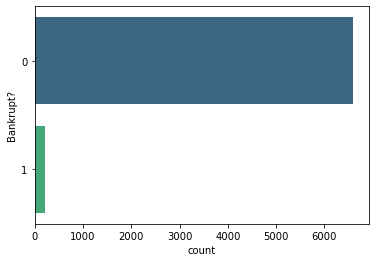

In [24]:
# Checking that the target distribution is imbalanced.

sns.countplot(y='Bankrupt?', data = ds, palette='viridis', orient = 'h');

In [25]:
ds["Bankrupt?"].value_counts(normalize=True)

0    0.967737
1    0.032263
Name: Bankrupt?, dtype: float64

In [26]:
# MutualInfoScores(ds.drop(columns="Bankrupt?"), ds["Bankrupt?"])

In [27]:
X = ds.copy(deep=True)

y = X["Bankrupt?"]
X = X.drop(columns=["Bankrupt?"])

## Data Preparation:

### Splitting the dataset:

In [28]:
# Split the dataset intro train and test sets.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                   shuffle = True, stratify=y, random_state=SEED)

### Correlation:
We remove features whose absolute correlation coefficient are greater than 0.9

In [29]:
correlated_cols = remove_correlated(x_train)
x_train = x_train.drop(columns=correlated_cols)
x_test = x_test.drop(columns=correlated_cols)

 ROA(C) before interest and depreciation before interest vs.  ROA(A) before interest and % after tax are highly correlated 0.9418288508327729
 ROA(C) before interest and depreciation before interest vs.  ROA(B) before interest and depreciation after tax are highly correlated 0.9861217517131242
 ROA(A) before interest and % after tax vs.  ROA(B) before interest and depreciation after tax are highly correlated 0.957838380759818
 ROA(A) before interest and % after tax vs.  Net Income to Total Assets are highly correlated 0.9564272011651113
 ROA(B) before interest and depreciation after tax vs.  Net Income to Total Assets are highly correlated 0.9130270278033344
 Operating Gross Margin vs.  Realized Sales Gross Margin are highly correlated 0.9994625329796241
 Operating Gross Margin vs.  Gross Profit to Sales are highly correlated 0.9999999896611498
 Realized Sales Gross Margin vs.  Gross Profit to Sales are highly correlated 0.9994624071720175
 Operating Profit Rate vs.  Pre-tax net Intere

### Dealing with outliers:
Random forests is efficient at detecting outliers in high-dimensional dataset https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest. Isolation forest algorithm randomly selects a feature and splits it between the min and max. This process is repeated recuresively to partition the outliers

In [30]:
print(x_train.shape)
print(x_test.shape)

(4773, 73)
(2046, 73)


In [31]:
x_train, x_test, y_train, y_test = remove_outliers(x_train, x_test, y_train, y_test)

In [32]:
print(x_train.shape)
print(x_test.shape)

(4717, 73)
(2021, 73)


In [33]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.971168
1    0.028832
Name: Bankrupt?, dtype: float64
0    0.969322
1    0.030678
Name: Bankrupt?, dtype: float64


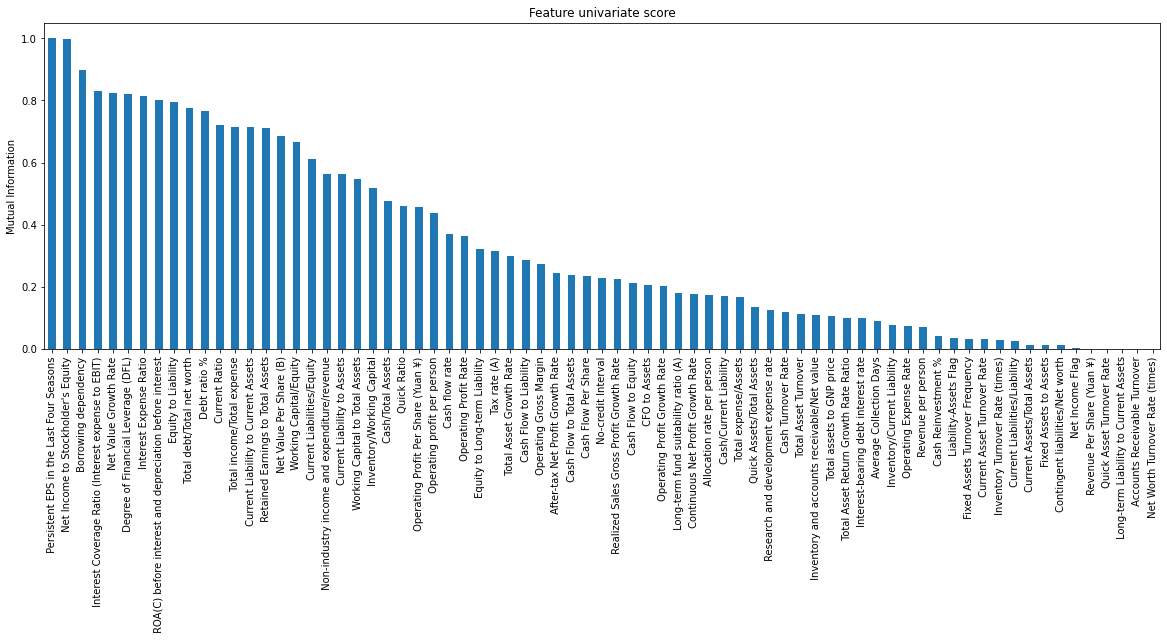

 Persistent EPS in the Last Four Seasons               1.000000
 Net Income to Stockholder's Equity                    0.998625
 Borrowing dependency                                  0.896846
 Interest Coverage Ratio (Interest expense to EBIT)    0.829523
 Net Value Growth Rate                                 0.824464
                                                         ...   
 Revenue Per Share (Yuan ¥)                            0.000000
 Quick Asset Turnover Rate                             0.000000
 Long-term Liability to Current Assets                 0.000000
 Accounts Receivable Turnover                          0.000000
 Net Worth Turnover Rate (times)                       0.000000
Length: 73, dtype: float64

In [34]:
MutualInfoScores(x_train, y_train)

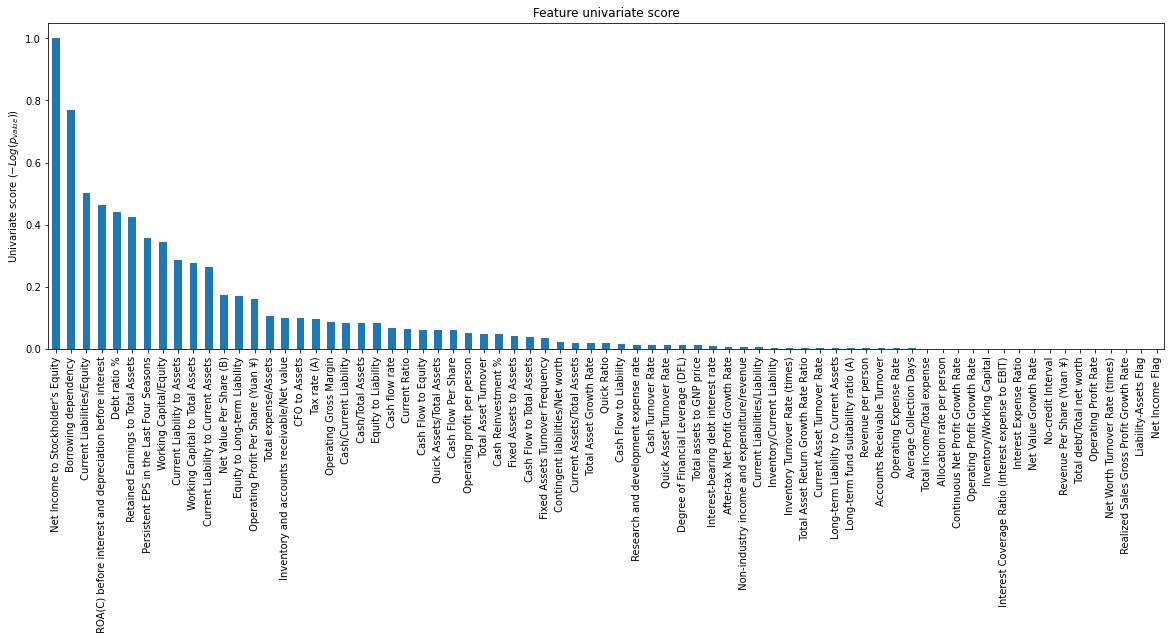

 Net Income to Stockholder's Equity                         1.000000
 Borrowing dependency                                       0.770567
 Current Liabilities/Equity                                 0.500427
 ROA(C) before interest and depreciation before interest    0.463902
 Debt ratio %                                               0.441154
 Retained Earnings to Total Assets                          0.425210
 Persistent EPS in the Last Four Seasons                    0.358444
 Working Capital/Equity                                     0.343314
 Current Liability to Assets                                0.285285
 Working Capital to Total Assets                            0.275719
 Current Liability to Current Assets                        0.264250
 Net Value Per Share (B)                                    0.173575
 Equity to Long-term Liability                              0.169901
 Operating Profit Per Share (Yuan ¥)                        0.159708
 Total expense/Assets             

In [35]:
f_scores = FTestScores(x_train, y_train)
f_scores.loc[f_scores > 0.1]

In [36]:
selector = SelectKBest(f_classif, k=len(f_scores.loc[f_scores > 0.1]))

# selecting the features:
selector.fit(x_train, y_train)

kept_columns = list(x_train.columns[selector.get_support()]) 

In [37]:
kept_columns

[' ROA(C) before interest and depreciation before interest',
 ' Net Value Per Share (B)',
 ' Persistent EPS in the Last Four Seasons',
 ' Operating Profit Per Share (Yuan ¥)',
 ' Debt ratio %',
 ' Borrowing dependency',
 ' Working Capital to Total Assets',
 ' Current Liability to Assets',
 ' Working Capital/Equity',
 ' Current Liabilities/Equity',
 ' Retained Earnings to Total Assets',
 ' Total expense/Assets',
 ' Equity to Long-term Liability',
 ' Current Liability to Current Assets',
 " Net Income to Stockholder's Equity"]

In [38]:
x_train = x_train[kept_columns]
x_test = x_test[kept_columns]

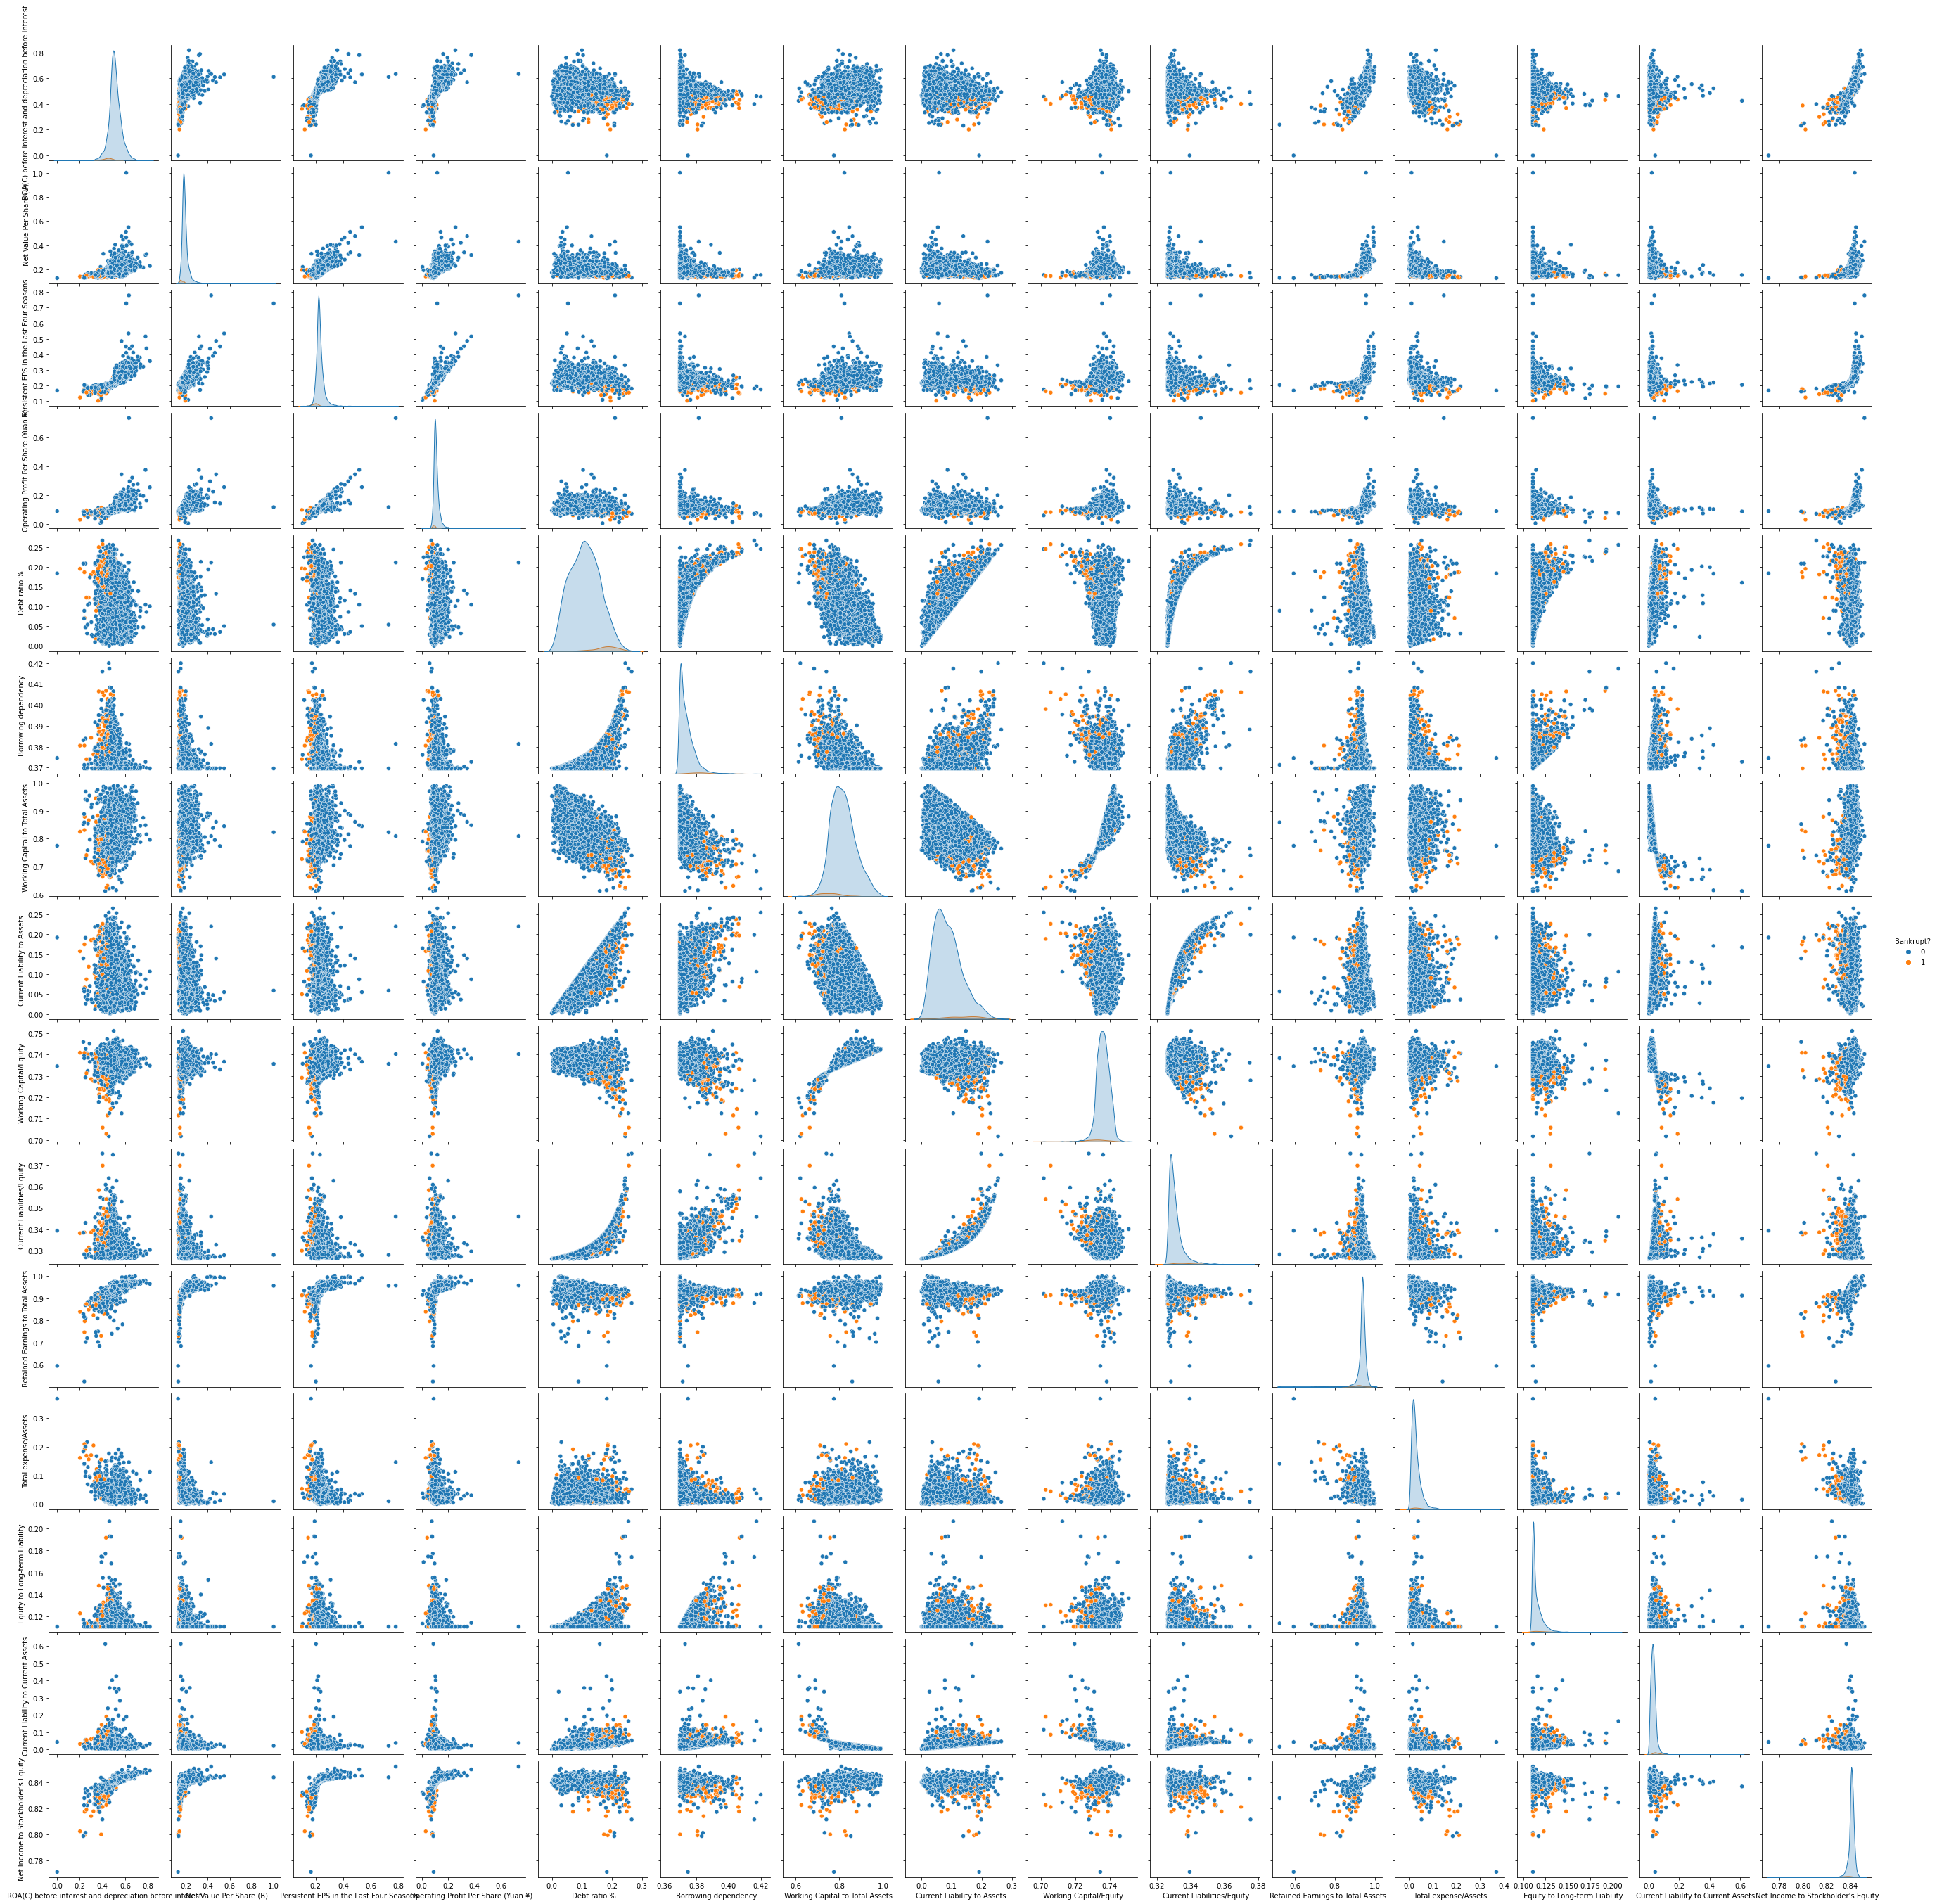

In [39]:
sns.pairplot(pd.concat([x_train, y_train], axis=1), hue="Bankrupt?")

## Data Normalization:

In [40]:
# We use the standard scaler in order to normalize the data:

scaler = StandardScaler() 
x_train = scaler.fit_transform(x_train) 
x_test = scaler.transform(x_test)

## Simple Model
First we try out a simple model to get a sense of number of hidden layers needed.

In [41]:
def simple_model(units, loss, x_train, y_train, x_test, y_test, epochs=50, batch_size=16, cw=None):
    '''
    units: a list for number of units in each layer. The length of the list determines the number of hidden layers
    loss: loss function to minimize
    '''
    model = Sequential()
    for u in units:
        model.add(layers.Dense(units=u, activation="relu"))
    
    # Last layer should always have 1 neuron with sigmoid activation function
    model.add(layers.Dense(units=1, activation="sigmoid"))
    model.compile(loss=loss, metrics=['binary_accuracy'])
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3,
        shuffle = True, stratify=y_train, random_state=SEED)
    EarlyStop = EarlyStopping(monitor='val_binary_accuracy', patience=5, verbose=0, restore_best_weights=True)
    CallBacksList = [EarlyStop,]  
    model.fit(x_train, y_train, epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        class_weight=cw,
        callbacks = CallBacksList,
        verbose='auto')
    
    y_pred_train_proba = model.predict(x_train)
    y_pred_test_proba = model.predict(x_test)
    y_pred_train = (y_pred_train_proba>0.5).astype(int)
    y_pred_test = (y_pred_test_proba>0.5).astype(int) 
    
    cm = metrics.confusion_matrix(y_test, y_pred_test)
    labels = ['True Neg','False Pos','False Neg','True Pos']
    categories = ['0', '1']
    make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='Blues')

Epoch 1/50
207/207 [==============================] - 2s 5ms/step - loss: 0.1486 - binary_accuracy: 0.9694 - val_loss: 0.0935 - val_binary_accuracy: 0.9739
Epoch 2/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0941 - binary_accuracy: 0.9709 - val_loss: 0.0892 - val_binary_accuracy: 0.9732
Epoch 3/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0878 - binary_accuracy: 0.9727 - val_loss: 0.0946 - val_binary_accuracy: 0.9654
Epoch 4/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0821 - binary_accuracy: 0.9736 - val_loss: 0.0869 - val_binary_accuracy: 0.9732
Epoch 5/50
207/207 [==============================] - 1s 4ms/step - loss: 0.0829 - binary_accuracy: 0.9739 - val_loss: 0.0851 - val_binary_accuracy: 0.9739
Epoch 6/50
207/207 [==============================] - 1s 4ms/step - loss: 0.0793 - binary_accuracy: 0.9730 - val_loss: 0.0886 - val_binary_accuracy: 0.9689


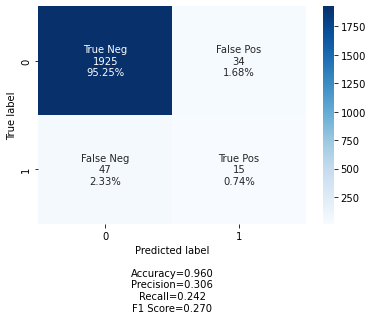

In [42]:
simple_model([64,32,16], tf.keras.losses.BinaryCrossentropy(), x_train, y_train, x_test, y_test)

Epoch 1/50
207/207 [==============================] - 2s 4ms/step - loss: 0.1686 - binary_accuracy: 0.9640 - val_loss: 0.0905 - val_binary_accuracy: 0.9753
Epoch 2/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0920 - binary_accuracy: 0.9715 - val_loss: 0.0882 - val_binary_accuracy: 0.9703
Epoch 3/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0874 - binary_accuracy: 0.9718 - val_loss: 0.0939 - val_binary_accuracy: 0.9661
Epoch 4/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0834 - binary_accuracy: 0.9706 - val_loss: 0.0842 - val_binary_accuracy: 0.9746
Epoch 5/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0826 - binary_accuracy: 0.9712 - val_loss: 0.0846 - val_binary_accuracy: 0.9753
Epoch 6/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0794 - binary_accuracy: 0.9721 - val_loss: 0.0893 - val_binary_accuracy: 0.9718


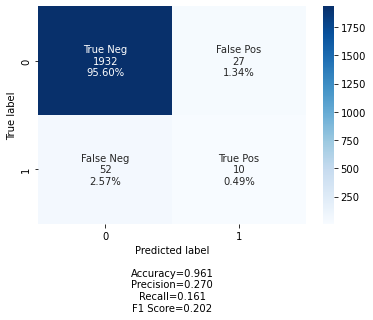

In [43]:
simple_model([64,32], tf.keras.losses.BinaryCrossentropy(), x_train, y_train, x_test, y_test)

Epoch 1/50
207/207 [==============================] - 2s 4ms/step - loss: 0.2226 - binary_accuracy: 0.9603 - val_loss: 0.1029 - val_binary_accuracy: 0.9710
Epoch 2/50
207/207 [==============================] - 1s 2ms/step - loss: 0.1019 - binary_accuracy: 0.9712 - val_loss: 0.0900 - val_binary_accuracy: 0.9710
Epoch 3/50
207/207 [==============================] - 1s 2ms/step - loss: 0.0922 - binary_accuracy: 0.9712 - val_loss: 0.0881 - val_binary_accuracy: 0.9710
Epoch 4/50
207/207 [==============================] - 1s 2ms/step - loss: 0.0864 - binary_accuracy: 0.9712 - val_loss: 0.0868 - val_binary_accuracy: 0.9710
Epoch 5/50
207/207 [==============================] - 1s 3ms/step - loss: 0.0849 - binary_accuracy: 0.9712 - val_loss: 0.0855 - val_binary_accuracy: 0.9710
Epoch 6/50
207/207 [==============================] - 1s 2ms/step - loss: 0.0807 - binary_accuracy: 0.9712 - val_loss: 0.0862 - val_binary_accuracy: 0.9718
Epoch 7/50
207/207 [==============================] - 1s 3ms/ste

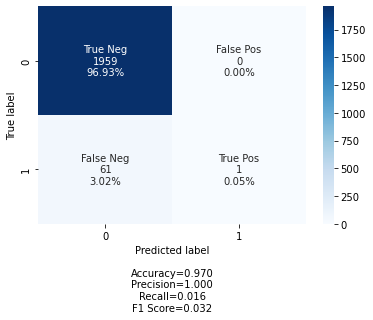

In [44]:
simple_model([32,16,4], tf.keras.losses.BinaryCrossentropy(), x_train, y_train, x_test, y_test)

A smaller neural network seems to generalize better for our dataset, because the dataset is small.

# Hyper parameters tuning:
- Focal Loss
https://towardsdatascience.com/focal-loss-a-better-alternative-for-cross-entropy-1d073d92d075 provides a good explanation. In essence focal loss function focuses on cases that are misclassfified, so it's useful when the classes are imbalanced. It takes a parameter gamma.

__Using Keras tuner:__

In [45]:
ClassWeights = dict(enumerate(class_weight.compute_class_weight('balanced', 
                            classes=np.unique(y_train), y=y_train)))
ClassWeights

{0: 0.5148439205413665, 1: 17.341911764705884}

In [46]:
tune_objective = 'val_recall'
EarlyStop = EarlyStopping(monitor=tune_objective, patience=5, verbose=0, restore_best_weights=True)

CallBacksList = [EarlyStop,]  

In [47]:
def kfold_split(x, y, k):
    x = np.array(x)
    y = np.array(y)
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)
    x_train, x_val, y_train, y_val = [], [], [], []
    for train_index, val_index in kfold.split(x, y):
        x_train.append(x[train_index])
        x_val.append(x[val_index])
        # Need to use y directly because y_train is Series
        y_train.append(y[train_index])
        y_val.append(y[val_index])
    return x_train, x_val, y_train, y_val


class MyHyperModel(kt.HyperModel):
    def __init__(self, metrics=None, k=3):
        self.k = k
        if metrics:
            self.metrics = metrics
        else:
            self.metrics= [
                "accuracy", 
                tf.keras.metrics.AUC(name="auc"), 
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
                f1
            ]

    def build(self ,hp):

        hp_units_1 = hp.Choice("Layer 1", [32, 48, 64])
        hp_units_2 = hp.Choice("Layer 2", [8, 16, 32]) # 64
        hp_units_3 = hp.Choice("Layer 3", [4, 8, 16]) # 32, 64, 16 
        hp_activation = hp.Choice("activation", ["sigmoid", "relu", "tanh"])
        hp_kernel_initializer = hp.Choice("kernel_initializer", ["glorot_uniform", "glorot_normal"])
        hp_learning_rate = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log", default=1e-3)  
        hp_loss = hp.Choice("loss_type", ["BC", "FL"])
        hp_gamma = hp.Choice("Gamma", [0.0, 0.5, 1.0, 2.0])
        hp_dropout = hp.Choice("rate", [0.2, 0.35, 0.5])
        
        model = Sequential()
    
        model.add(layers.Dense(units = hp_units_1,
                        kernel_initializer = hp_kernel_initializer,
                        kernel_regularizer = tf.keras.regularizers.L2(0.1),
                        activation = hp_activation,
                        input_dim = x_train.shape[-1]   
                           )) 
    
        # Tune whether to use dropout.
        if hp.Boolean("Dropout 1"):
            model.add(layers.Dropout(rate=hp_dropout))
    
        model.add(layers.Dense(units = hp_units_2, 
                            kernel_initializer = hp_kernel_initializer,    
                            activation = hp_activation))
            
        if hp.Boolean("Dropout 2"):
            model.add(layers.Dropout(rate=hp_dropout))
            
        model.add(layers.Dense(units = hp_units_3, 
                            kernel_initializer = hp_kernel_initializer,    
                            activation = hp_activation))
            
        if hp.Boolean("Dropout 3"):
            model.add(layers.Dropout(rate=hp_dropout))
            
        model.add(layers.Dense(units=1, 
                            kernel_initializer = hp_kernel_initializer,
                            activation="sigmoid"))
            
        optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate)
        if hp_loss == "BC":
            with hp.conditional_scope("loss_type", ["BC"]):
                model.compile(optimizer=optimizer,
                    loss = tf.keras.losses.BinaryCrossentropy(),
                    metrics= self.metrics)
        if hp_loss == "FL":
            with hp.conditional_scope("loss_type", ["FL"]):
                model.compile(optimizer=optimizer,
                    loss = tf.keras.losses.BinaryFocalCrossentropy(gamma = hp_gamma), 
                    metrics= self.metrics)
    
        return model

    def kfold_split(self, x, y):
        x = np.array(x)
        y = np.array(y)
        kfold = StratifiedKFold(n_splits=self.k, shuffle=True, random_state=SEED)
        x_train, x_val, y_train, y_val = [], [], [], []
        for train_index, val_index in kfold.split(x, y):
            x_train.append(x[train_index])
            x_val.append(x[val_index])
            # Need to use y directly because y_train is Series
            y_train.append(y[train_index])
            y_val.append(y[val_index])
        return x_train, x_val, y_train, y_val


    def fit(self, hp, model, x, y, **kwargs):
        hp_batch_size = hp.Choice("batch_size", [16, 32, 64])
        
        measures = ['val_precision', 'val_recall', 'val_f1', 'val_auc']
        results = pd.DataFrame(index=range(self.k), columns=measures)
        x_train, x_val, y_train, y_val = kfold_split(x, y, self.k)
        for i in range(self.k):
            hist = None
            try:
                hist = model.fit(
                    x_train[i],
                    y_train[i],
                    # Tune whether to shuffle the data in each epoch.
                    shuffle=hp.Boolean("shuffle"),
                    validation_data=(x_val[i], y_val[i]),
                    batch_size = hp_batch_size,
                    class_weight = ClassWeights,
                    **kwargs,
                )
                for m in measures:
                    results.iloc[i][m] = hist.history[m][-1]

            except:
                results.iloc[i] = 0

        avg_measures = {}
        for m in measures:
            avg_measures[m] = results[m].mean()
        return avg_measures

In [48]:
tuner = kt.BayesianOptimization(
    hypermodel = MyHyperModel(),
    objective = kt.Objective(tune_objective, direction="max"), 
    seed = SEED,
    max_trials = MAX_TRIALS,
    overwrite=True,
    directory = 'Deep_learning_project',
    project_name = "Default_predictions"
)

In [49]:
tuner.search(x_train, y_train,
             epochs = 100,
             verbose = 2,
             initial_epoch = 0,
             callbacks = CallBacksList,
             use_multiprocessing = True,
            )

Trial 50 Complete [00h 00m 22s]
val_recall: 0.926086962223053

Best val_recall So Far: 1.0
Total elapsed time: 00h 27m 19s
INFO:tensorflow:Oracle triggered exit


In [50]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal hyper parameters are:
The first layer: {best_hps.get("Layer 1")}. \n
The second layer: {best_hps.get("Layer 2")}. \n
The third layer: {best_hps.get("Layer 3")}. \n
The activation function: {best_hps.get("activation")}. \n
The kernel initializer: {best_hps.get("kernel_initializer")}. \n
The loss function: {best_hps.get("loss_type")}. \n  
The learning rate: {best_hps.get("learning_rate")}. \n
The batch size: {best_hps.get("batch_size")}. \n
Dropout 1: {best_hps.get("Dropout 1")}. \n
Dropout 2: {best_hps.get("Dropout 2")}. \n
Dropout 3: {best_hps.get("Dropout 3")}. \n
Shuffle: {best_hps.get("shuffle")}. \n
Gamma: {best_hps.get("Gamma")}. \n
Dropout rate: {best_hps.get("rate")} \n
""")


The hyperparameter search is complete. The optimal hyper parameters are:
The first layer: 64. 

The second layer: 8. 

The third layer: 16. 

The activation function: sigmoid. 

The kernel initializer: glorot_normal. 

The loss function: BC. 
  
The learning rate: 0.0001. 

The batch size: 16. 

Dropout 1: True. 

Dropout 2: True. 

Dropout 3: False. 

Shuffle: False. 

Gamma: 2.0. 

Dropout rate: 0.5 




In [51]:
best_model_params = MyHyperModel().build(best_hps)
best_model_params.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                1024      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 8)                 520       
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_6 (Dense)             (None, 16)                144       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,705
Trainable params: 1,705
Non-traina

***

### Visualize Best Model K-fold Result

In [52]:
def get_mean_metrics(model, x, y, k=5, n_epochs=50):
    mean_values = {"loss":[0]*n_epochs, "accuracy":[0]*n_epochs, "precision":[0]*n_epochs, "recall":[0]*n_epochs,
                   "f1":[0]*n_epochs, "auc":[0]*n_epochs}
    mean_values_val = {"loss":[0]*n_epochs, "accuracy":[0]*n_epochs, "precision":[0]*n_epochs, "recall":[0]*n_epochs,
                       "f1":[0]*n_epochs, "auc":[0]*n_epochs}
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1', 'auc']


    x_train, x_val, y_train, y_val = kfold_split(x, y, k)

    for i in range(k):
        hist = model.fit(x_train[i],
            y_train[i],
            verbose=0,             
            epochs = n_epochs,
            # Tune whether to shuffle the data in each epoch.
            shuffle= best_hps.get("shuffle"),
            validation_data = (x_val[i], y_val[i]),
            batch_size = best_hps.get("batch_size"),
            class_weight = ClassWeights,
            )
        for m in metrics:
            
            mean_values[m] = list(map(add, mean_values[m], hist.history[f"{m}"]))
            mean_values_val[m] = list(map(add, mean_values_val[m], hist.history[f"val_{m}"]))
    

    for m in metrics:
        mean_values[m] = np.array(mean_values[m])/len(metrics)
        mean_values_val[m] = np.array(mean_values_val[m])/len(metrics)
    return mean_values, mean_values_val

In [54]:
# This function plot the "metrics" and the "val_metrics" values.
def visualize_mean_metrics(mean_values, mean_values_val, metrics):
    """
    history: history of the model.
    metrics: the metrics in history to plot.
    title: Title of the plot.
    """
    fig, ax = plt.subplots(len(metrics), 1, figsize=(20,15))
    
    for idx, m in enumerate(metrics):
    
        loss = mean_values[m]
        val_loss = mean_values_val[m]
        epochs = range(1, len(loss)+1)
        ax[idx].plot(epochs, loss, "g", label=f"Training {m}")
        ax[idx].plot(epochs, val_loss, "b", label=f"Validation {m}")
        ax[idx].legend(loc="best")
    plt.xlabel("Epochs")
    fig.tight_layout()
    fig.show();

In [53]:
mean_values, mean_values_val = get_mean_metrics(best_model_params, x_train, y_train)

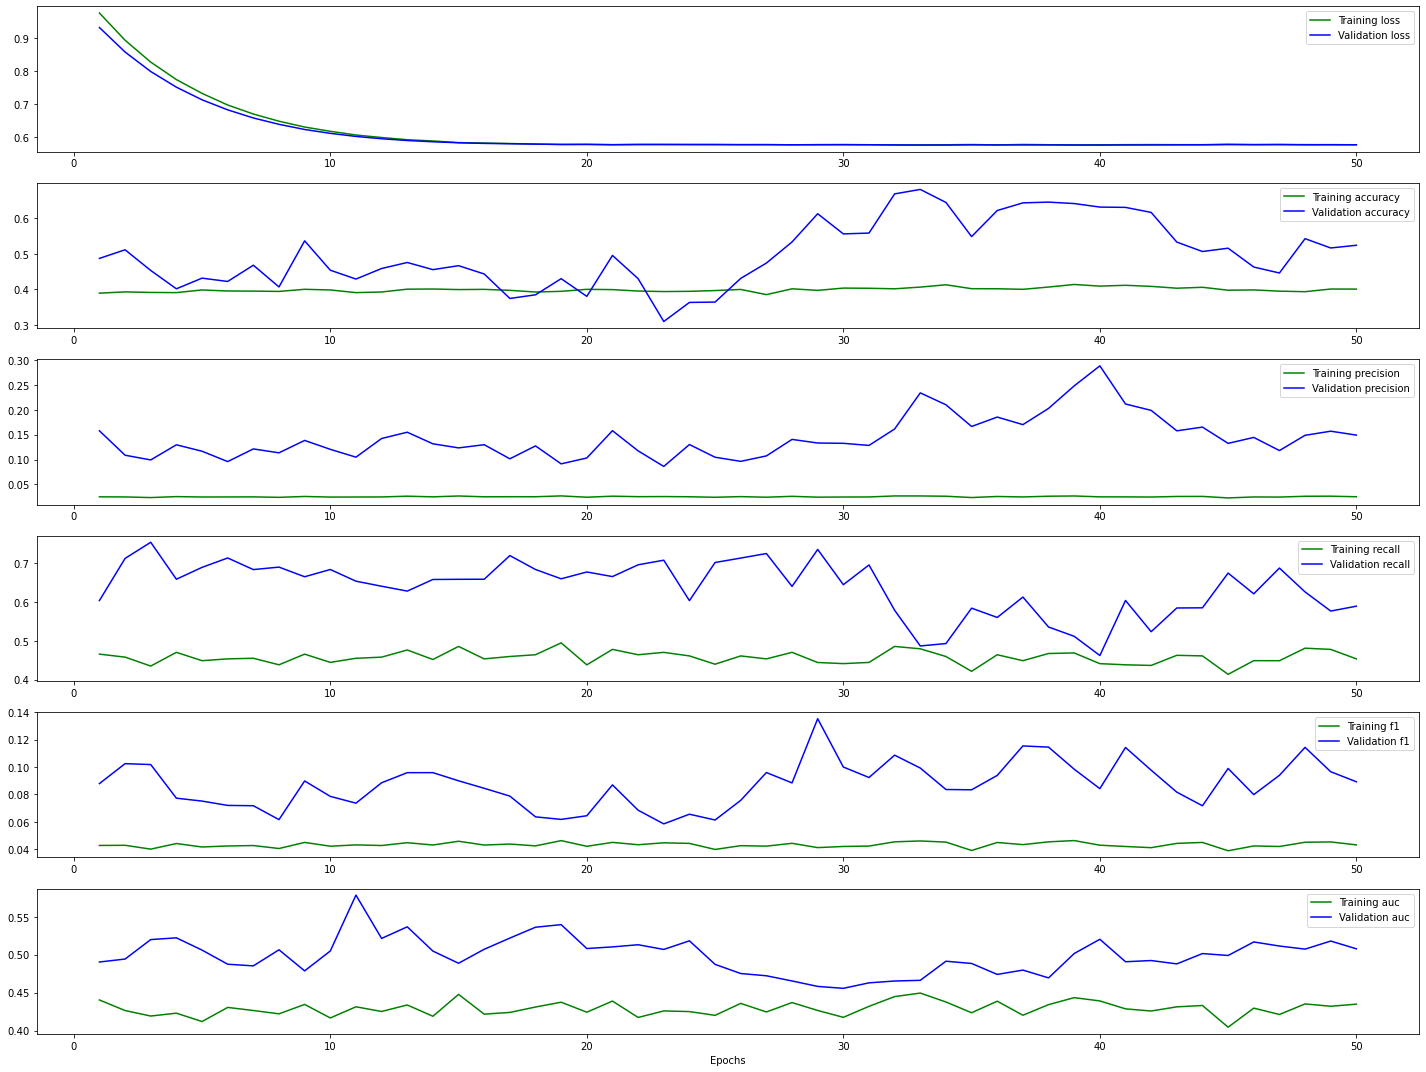

In [55]:
visualize_mean_metrics(mean_values, mean_values_val, ['loss', 'accuracy', 'precision', 'recall', 'f1', 'auc'])

### __Fit Model with All Training Data:__

In [56]:
best_model_params.fit(x_train,
    y_train,
    epochs = 100,
    # Tune whether to shuffle the data in each epoch.
    shuffle= best_hps.get("shuffle"),
    batch_size = best_hps.get("batch_size"),
    callbacks = CallBacksList,                  
    class_weight = ClassWeights,
)

Epoch 1/100
295/295 [==============================] - 2s 3ms/step - loss: 0.6922 - accuracy: 0.4713 - auc: 0.5493 - precision: 0.0325 - recall: 0.6029 - f1: 0.0551
Epoch 2/100
295/295 [==============================] - 1s 3ms/step - loss: 0.6904 - accuracy: 0.4772 - auc: 0.5665 - precision: 0.0336 - recall: 0.6176 - f1: 0.0558
Epoch 3/100
295/295 [==============================] - 1s 3ms/step - loss: 0.6922 - accuracy: 0.4762 - auc: 0.5318 - precision: 0.0317 - recall: 0.5809 - f1: 0.0552
Epoch 4/100
295/295 [==============================] - 1s 3ms/step - loss: 0.6940 - accuracy: 0.4543 - auc: 0.5097 - precision: 0.0301 - recall: 0.5735 - f1: 0.0516
Epoch 5/100
295/295 [==============================] - 1s 4ms/step - loss: 0.6938 - accuracy: 0.4594 - auc: 0.5188 - precision: 0.0318 - recall: 0.6029 - f1: 0.0564
Epoch 6/100
295/295 [==============================] - 1s 3ms/step - loss: 0.6926 - accuracy: 0.4639 - auc: 0.5270 - precision: 0.0280 - recall: 0.5221 - f1: 0.0475
Epoch 7/10

295/295 [==============================] - 1s 4ms/step - loss: 0.6936 - accuracy: 0.4446 - auc: 0.5180 - precision: 0.0320 - recall: 0.6250 - f1: 0.0537
Epoch 19/100
295/295 [==============================] - 1s 3ms/step - loss: 0.6933 - accuracy: 0.4575 - auc: 0.5087 - precision: 0.0291 - recall: 0.5515 - f1: 0.0506
Epoch 20/100
295/295 [==============================] - 1s 3ms/step - loss: 0.6948 - accuracy: 0.4386 - auc: 0.5061 - precision: 0.0310 - recall: 0.6103 - f1: 0.0537
Epoch 21/100
295/295 [==============================] - 1s 4ms/step - loss: 0.6912 - accuracy: 0.4653 - auc: 0.5568 - precision: 0.0329 - recall: 0.6176 - f1: 0.0560
Epoch 22/100
295/295 [==============================] - 1s 4ms/step - loss: 0.6940 - accuracy: 0.4817 - auc: 0.5120 - precision: 0.0301 - recall: 0.5441 - f1: 0.0548
Epoch 23/100
295/295 [==============================] - 1s 4ms/step - loss: 0.6955 - accuracy: 0.4692 - auc: 0.4784 - precision: 0.0260 - recall: 0.4779 - f1: 0.0441
Epoch 24/100
295/

295/295 [==============================] - 1s 3ms/step - loss: 0.6914 - accuracy: 0.4870 - auc: 0.5413 - precision: 0.0308 - recall: 0.5515 - f1: 0.0524
Epoch 37/100
295/295 [==============================] - 1s 3ms/step - loss: 0.6891 - accuracy: 0.5088 - auc: 0.5896 - precision: 0.0393 - recall: 0.6838 - f1: 0.0649
Epoch 38/100
295/295 [==============================] - 1s 4ms/step - loss: 0.6916 - accuracy: 0.5073 - auc: 0.5385 - precision: 0.0329 - recall: 0.5662 - f1: 0.0573
Epoch 39/100
295/295 [==============================] - 1s 4ms/step - loss: 0.6911 - accuracy: 0.4952 - auc: 0.5579 - precision: 0.0329 - recall: 0.5809 - f1: 0.0545
Epoch 40/100
295/295 [==============================] - 1s 3ms/step - loss: 0.6911 - accuracy: 0.5118 - auc: 0.5575 - precision: 0.0336 - recall: 0.5735 - f1: 0.0559
Epoch 41/100
295/295 [==============================] - 1s 3ms/step - loss: 0.6937 - accuracy: 0.4995 - auc: 0.5350 - precision: 0.0328 - recall: 0.5735 - f1: 0.0554
Epoch 42/100
295/

295/295 [==============================] - 1s 4ms/step - loss: 0.6913 - accuracy: 0.4895 - auc: 0.5522 - precision: 0.0340 - recall: 0.6103 - f1: 0.0577
Epoch 54/100
295/295 [==============================] - 1s 4ms/step - loss: 0.6946 - accuracy: 0.4855 - auc: 0.5128 - precision: 0.0276 - recall: 0.4926 - f1: 0.0463
Epoch 55/100
295/295 [==============================] - 1s 4ms/step - loss: 0.6946 - accuracy: 0.4857 - auc: 0.5157 - precision: 0.0304 - recall: 0.5441 - f1: 0.0510
Epoch 56/100
295/295 [==============================] - 1s 4ms/step - loss: 0.6915 - accuracy: 0.4946 - auc: 0.5562 - precision: 0.0340 - recall: 0.6029 - f1: 0.0593
Epoch 57/100
295/295 [==============================] - 1s 3ms/step - loss: 0.6933 - accuracy: 0.5024 - auc: 0.5343 - precision: 0.0314 - recall: 0.5441 - f1: 0.0525
Epoch 58/100
295/295 [==============================] - 1s 3ms/step - loss: 0.6910 - accuracy: 0.5071 - auc: 0.5535 - precision: 0.0345 - recall: 0.5956 - f1: 0.0561
Epoch 59/100
295/

295/295 [==============================] - 1s 4ms/step - loss: 0.6899 - accuracy: 0.5058 - auc: 0.5740 - precision: 0.0359 - recall: 0.6250 - f1: 0.0623
Epoch 72/100
295/295 [==============================] - 1s 4ms/step - loss: 0.6918 - accuracy: 0.5046 - auc: 0.5505 - precision: 0.0331 - recall: 0.5735 - f1: 0.0545
Epoch 73/100
295/295 [==============================] - 1s 4ms/step - loss: 0.6931 - accuracy: 0.4997 - auc: 0.5398 - precision: 0.0336 - recall: 0.5882 - f1: 0.0566
Epoch 74/100
295/295 [==============================] - 1s 3ms/step - loss: 0.6927 - accuracy: 0.4855 - auc: 0.5434 - precision: 0.0330 - recall: 0.5956 - f1: 0.0534
Epoch 75/100
295/295 [==============================] - 1s 4ms/step - loss: 0.6941 - accuracy: 0.4946 - auc: 0.5261 - precision: 0.0321 - recall: 0.5662 - f1: 0.0547
Epoch 76/100
295/295 [==============================] - 1s 3ms/step - loss: 0.6896 - accuracy: 0.4921 - auc: 0.5759 - precision: 0.0346 - recall: 0.6176 - f1: 0.0570
Epoch 77/100
295/

295/295 [==============================] - 1s 4ms/step - loss: 0.6905 - accuracy: 0.5101 - auc: 0.5667 - precision: 0.0315 - recall: 0.5368 - f1: 0.0495
Epoch 89/100
295/295 [==============================] - 1s 4ms/step - loss: 0.6938 - accuracy: 0.5132 - auc: 0.5443 - precision: 0.0337 - recall: 0.5735 - f1: 0.0575
Epoch 90/100
295/295 [==============================] - 1s 4ms/step - loss: 0.6944 - accuracy: 0.5101 - auc: 0.5438 - precision: 0.0331 - recall: 0.5662 - f1: 0.0554
Epoch 91/100
295/295 [==============================] - 1s 3ms/step - loss: 0.6886 - accuracy: 0.5035 - auc: 0.5900 - precision: 0.0354 - recall: 0.6176 - f1: 0.0591
Epoch 92/100
295/295 [==============================] - 1s 3ms/step - loss: 0.6949 - accuracy: 0.4893 - auc: 0.5322 - precision: 0.0313 - recall: 0.5588 - f1: 0.0536
Epoch 93/100
295/295 [==============================] - 1s 3ms/step - loss: 0.6931 - accuracy: 0.5018 - auc: 0.5524 - precision: 0.0325 - recall: 0.5662 - f1: 0.0572
Epoch 94/100
295/

In [57]:
best_model_params.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                1024      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 8)                 520       
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_6 (Dense)             (None, 16)                144       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,705
Trainable params: 1,705
Non-traina

              precision    recall  f1-score   support

  No Default       0.99      0.82      0.90      1959
     Default       0.13      0.85      0.23        62

    accuracy                           0.82      2021
   macro avg       0.56      0.84      0.57      2021
weighted avg       0.97      0.82      0.88      2021



Train      Test
ACCURACY   0.825525  0.824839
PRECISION  0.131042  0.133166
RECALL     0.860230  0.839364
F1 SCORE   0.565158  0.565804
AUC        0.860230  0.839364

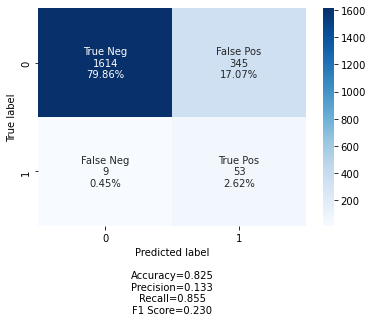

In [58]:
y_pred_test_proba=model_evaluation(best_model_params, x_train, y_train, x_test, y_test)

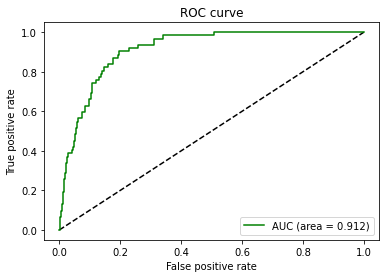

In [59]:
auc_plot(y_test, y_pred_test_proba)

***

### __Building the model using the best hyperparameters and S.M.O.T.E:__

In [60]:
# S.M.O.T.E

sm = SMOTE(k_neighbors=5, random_state=SEED)
x_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)

In [61]:
best_model_params_sm = MyHyperModel().build(best_hps)

In [62]:
best_model_params_sm.fit(x_train_sm,
            y_train_sm,
            epochs = 100,
            # Tune whether to shuffle the data in each epoch.
            shuffle= best_hps.get("shuffle"),
            batch_size = best_hps.get("batch_size"),
            callbacks = CallBacksList,
            )

Epoch 1/100
573/573 [==============================] - 3s 2ms/step - loss: 2.5659 - accuracy: 0.5143 - auc: 0.5248 - precision: 0.5566 - recall: 0.1406 - f1: 0.1015
Epoch 2/100
573/573 [==============================] - 1s 2ms/step - loss: 1.7307 - accuracy: 0.5196 - auc: 0.5263 - precision: 0.5434 - recall: 0.2462 - f1: 0.1668
Epoch 3/100
573/573 [==============================] - 1s 2ms/step - loss: 1.2551 - accuracy: 0.5242 - auc: 0.5230 - precision: 0.5381 - recall: 0.3418 - f1: 0.2184
Epoch 4/100
573/573 [==============================] - 1s 2ms/step - loss: 0.9869 - accuracy: 0.5135 - auc: 0.5105 - precision: 0.5179 - recall: 0.3918 - f1: 0.2407
Epoch 5/100
573/573 [==============================] - 1s 2ms/step - loss: 0.8378 - accuracy: 0.5080 - auc: 0.5060 - precision: 0.5096 - recall: 0.4231 - f1: 0.2570
Epoch 6/100
573/573 [==============================] - 1s 2ms/step - loss: 0.7601 - accuracy: 0.5120 - auc: 0.5030 - precision: 0.5138 - recall: 0.4482 - f1: 0.2684
Epoch 7/10

573/573 [==============================] - 1s 2ms/step - loss: 0.6975 - accuracy: 0.5070 - auc: 0.5015 - precision: 0.5072 - recall: 0.4923 - f1: 0.2938
Epoch 19/100
573/573 [==============================] - 1s 2ms/step - loss: 0.6979 - accuracy: 0.5031 - auc: 0.4977 - precision: 0.5031 - recall: 0.4916 - f1: 0.2917
Epoch 20/100
573/573 [==============================] - 2s 3ms/step - loss: 0.6983 - accuracy: 0.5020 - auc: 0.4961 - precision: 0.5020 - recall: 0.4916 - f1: 0.2861
Epoch 21/100
573/573 [==============================] - 1s 2ms/step - loss: 0.6970 - accuracy: 0.5061 - auc: 0.5077 - precision: 0.5063 - recall: 0.4905 - f1: 0.2935
Epoch 22/100
573/573 [==============================] - 1s 2ms/step - loss: 0.6964 - accuracy: 0.5105 - auc: 0.5105 - precision: 0.5106 - recall: 0.5034 - f1: 0.2965
Epoch 23/100
573/573 [==============================] - 1s 3ms/step - loss: 0.6976 - accuracy: 0.5080 - auc: 0.5022 - precision: 0.5081 - recall: 0.4988 - f1: 0.2947
Epoch 24/100
573/

573/573 [==============================] - 2s 3ms/step - loss: 0.6972 - accuracy: 0.5097 - auc: 0.5138 - precision: 0.5099 - recall: 0.4990 - f1: 0.2985
Epoch 37/100
573/573 [==============================] - 1s 2ms/step - loss: 0.6966 - accuracy: 0.5080 - auc: 0.5186 - precision: 0.5080 - recall: 0.5069 - f1: 0.3074
Epoch 38/100
573/573 [==============================] - 1s 2ms/step - loss: 0.6962 - accuracy: 0.5154 - auc: 0.5233 - precision: 0.5158 - recall: 0.5023 - f1: 0.3010
Epoch 39/100
573/573 [==============================] - 2s 3ms/step - loss: 0.6963 - accuracy: 0.5178 - auc: 0.5247 - precision: 0.5180 - recall: 0.5123 - f1: 0.3054
Epoch 40/100
573/573 [==============================] - 2s 3ms/step - loss: 0.6968 - accuracy: 0.5158 - auc: 0.5218 - precision: 0.5162 - recall: 0.5058 - f1: 0.3072
Epoch 41/100
573/573 [==============================] - 2s 4ms/step - loss: 0.6956 - accuracy: 0.5208 - auc: 0.5300 - precision: 0.5216 - recall: 0.5036 - f1: 0.3063
Epoch 42/100
573/

573/573 [==============================] - 2s 3ms/step - loss: 0.6933 - accuracy: 0.5419 - auc: 0.5650 - precision: 0.5428 - recall: 0.5315 - f1: 0.3315
Epoch 54/100
573/573 [==============================] - 1s 3ms/step - loss: 0.6925 - accuracy: 0.5506 - auc: 0.5708 - precision: 0.5516 - recall: 0.5414 - f1: 0.3349
Epoch 55/100
573/573 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5469 - auc: 0.5708 - precision: 0.5481 - recall: 0.5348 - f1: 0.3376
Epoch 56/100
573/573 [==============================] - 1s 2ms/step - loss: 0.6907 - accuracy: 0.5568 - auc: 0.5829 - precision: 0.5578 - recall: 0.5475 - f1: 0.3422
Epoch 57/100
573/573 [==============================] - 2s 3ms/step - loss: 0.6919 - accuracy: 0.5564 - auc: 0.5807 - precision: 0.5585 - recall: 0.5390 - f1: 0.3388
Epoch 58/100
573/573 [==============================] - 3s 4ms/step - loss: 0.6912 - accuracy: 0.5588 - auc: 0.5845 - precision: 0.5601 - recall: 0.5484 - f1: 0.3459
Epoch 59/100
573/

573/573 [==============================] - 1s 3ms/step - loss: 0.6761 - accuracy: 0.6190 - auc: 0.6649 - precision: 0.6211 - recall: 0.6103 - f1: 0.3838
Epoch 72/100
573/573 [==============================] - 2s 3ms/step - loss: 0.6775 - accuracy: 0.6190 - auc: 0.6632 - precision: 0.6217 - recall: 0.6079 - f1: 0.3865
Epoch 73/100
573/573 [==============================] - 2s 3ms/step - loss: 0.6762 - accuracy: 0.6182 - auc: 0.6689 - precision: 0.6203 - recall: 0.6095 - f1: 0.3848
Epoch 74/100
573/573 [==============================] - 2s 3ms/step - loss: 0.6723 - accuracy: 0.6250 - auc: 0.6793 - precision: 0.6274 - recall: 0.6154 - f1: 0.3884
Epoch 75/100
573/573 [==============================] - 1s 3ms/step - loss: 0.6664 - accuracy: 0.6380 - auc: 0.6968 - precision: 0.6415 - recall: 0.6254 - f1: 0.3919
Epoch 76/100
573/573 [==============================] - 1s 2ms/step - loss: 0.6694 - accuracy: 0.6367 - auc: 0.6897 - precision: 0.6387 - recall: 0.6291 - f1: 0.3959
Epoch 77/100
573/

573/573 [==============================] - 1s 3ms/step - loss: 0.6405 - accuracy: 0.6887 - auc: 0.7561 - precision: 0.6933 - recall: 0.6769 - f1: 0.4278
Epoch 89/100
573/573 [==============================] - 1s 3ms/step - loss: 0.6431 - accuracy: 0.6841 - auc: 0.7513 - precision: 0.6915 - recall: 0.6649 - f1: 0.4191
Epoch 90/100
573/573 [==============================] - 1s 2ms/step - loss: 0.6411 - accuracy: 0.6943 - auc: 0.7566 - precision: 0.7005 - recall: 0.6787 - f1: 0.4287
Epoch 91/100
573/573 [==============================] - 1s 3ms/step - loss: 0.6332 - accuracy: 0.6982 - auc: 0.7685 - precision: 0.7053 - recall: 0.6809 - f1: 0.4323
Epoch 92/100
573/573 [==============================] - 2s 3ms/step - loss: 0.6334 - accuracy: 0.7051 - auc: 0.7693 - precision: 0.7134 - recall: 0.6857 - f1: 0.4288
Epoch 93/100
573/573 [==============================] - 2s 3ms/step - loss: 0.6339 - accuracy: 0.7015 - auc: 0.7680 - precision: 0.7085 - recall: 0.6846 - f1: 0.4289
Epoch 94/100
573/

In [63]:
best_model_params_sm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                1024      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 8)                 520       
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_10 (Dense)            (None, 16)                144       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,705
Trainable params: 1,705
Non-traina

              precision    recall  f1-score   support

  No Default       1.00      0.64      0.78      1959
     Default       0.08      0.98      0.15        62

    accuracy                           0.65      2021
   macro avg       0.54      0.81      0.46      2021
weighted avg       0.97      0.65      0.76      2021



Train      Test
ACCURACY   0.648505  0.648194
PRECISION  0.072952  0.079118
RECALL     0.797631  0.810721
F1 SCORE   0.457481  0.462447
AUC        0.797631  0.810721

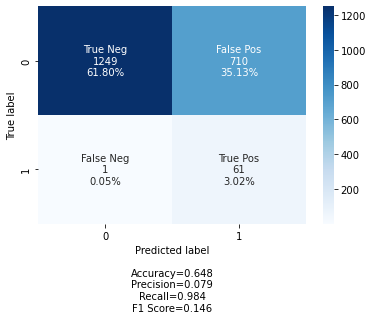

In [64]:
y_pred_test_proba = model_evaluation(best_model_params_sm, x_train, y_train, x_test, y_test)

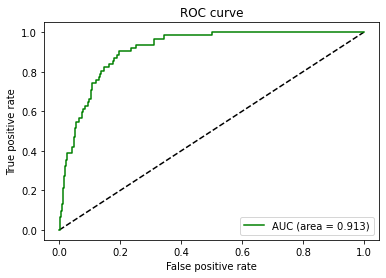

In [65]:
auc_plot(y_test, y_pred_test_proba)

***

### __Getting the best tuned model with the best hyper parameters:__

In [66]:
best_model = tuner.get_best_models(1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1024      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 16)                144       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,705
Trainable params: 1,705
Non-trainabl

              precision    recall  f1-score   support

  No Default       0.00      0.00      0.00      1959
     Default       0.03      1.00      0.06        62

    accuracy                           0.03      2021
   macro avg       0.02      0.50      0.03      2021
weighted avg       0.00      0.03      0.00      2021



Train      Test
ACCURACY   0.028832  0.030678
PRECISION  0.028832  0.030678
RECALL     0.500000  0.500000
F1 SCORE   0.028024  0.029765
AUC        0.500000  0.500000

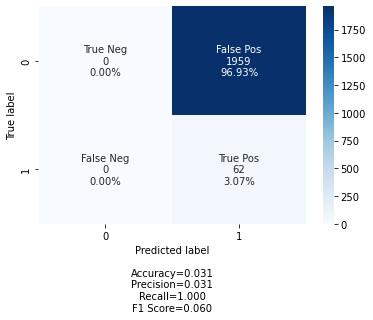

In [67]:
y_pred_test_proba = model_evaluation(best_model, x_train, y_train, x_test, y_test)

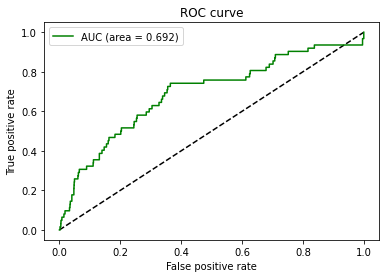

In [68]:
auc_plot(y_test, y_pred_test_proba)

***

In [69]:
t2 = time.perf_counter()
print('Time taken to run in minutes:',(t2-t1)/60.0)

Time taken to run in minutes: 40.509131925
